In [1]:
import awkward as ak
import numpy as np
import time
import coffea
import uproot
import hist
import vector
print("awkward version ", ak.__version__)
print("coffea version ", coffea.__version__)
from coffea import util, processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema, BaseSchema
from collections import defaultdict
import pickle
from distributed.diagnostics.plugin import UploadDirectory
import os
from plot_utils import adjust_plot
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use("CMS")


awkward version  1.10.3
coffea version  0.7.21


In [2]:
class QCDProcessor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.axis.StrCategory([], growth=True, name="dataset", label="Primary dataset")
        frac_axis = hist.axis.Regular(150, 0, 2.0, name="frac", label=r"Fraction")
        ptgen_axis = hist.axis.Variable([200,260,350,460,550,650,760,13000], name="ptgen", label=r"p_{T,RECO} (GeV)")
        n_axis = hist.axis.Regular(5, 0, 5, name="n", label=r"Number")
        pt_axis = hist.axis.Variable([10,20,30,40,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000], name="pt", label=r"$p_{T}$ [GeV]") #erased 4000 and 5000
        pt_raw_axis = hist.axis.Variable([10,20,30,40,50,60,70,80,90,
                                     100,120,140,160,180,
                                     200,250,300,350,400,450,500,
                                     600,700,800,900,1000,
                                     1500,2000,3000], name="pt_raw", label=r"$p_{T}$ [GeV]") #erased 4000 and 5000
        #pileup_axis = hist.axis.Regular(9,0,90, name = "pileup", label = r"$\mu$" )
        pileup_axis = hist.axis.Variable([0,10,20,30,40,50,60,90],name = "pileup", label = r"$\mu$" )
        #eta_axis = hist.axis.Regular(15, -4,4, name = "eta", label = r"$eta$")
        # eta_axis = hist.axis.Variable([0, 0.261, 0.522, 0.783,  1.044, 1.305, 1.566, 1.74, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853,
        #                               2.964, 3.139, 5],name = "eta", label = r"$\eta$")
        #eta_axis = hist.axis.Variable([-5.191, -3.839, -3.489, -3.139, -2.964, -2.853, -2.65, -2.5, -2.322,-2.172,-2.043, -1.93, -1.74, -1.566,-1.305,-1.044 ,-0.783 ,-0.522, -0.261, 0, 0.261, 0.522, 0.783, 1.044, 1.305, 1.566, 1.74, 1.93, 2.043, 2.172, 2.322, 2.5, 2.65, 2.853,], name = "eta", label = r"$\eta$")
        
        eta_axis = hist.axis.Variable([0, 1.305,  2.5, 2.65, 2.853,
                                       5.191],name = "eta", label = r"$\eta$")
        
        
        h_njet_gen = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")
        h_njet_reco = hist.Hist(dataset_axis, n_axis, storage="weight", label="Counts")
        
        h_pt_reco_over_gen = hist.Hist( dataset_axis, pt_axis,n_axis, frac_axis, eta_axis, pileup_axis, storage = "weight", label = "Counts")
        h_pt_reco_over_raw = hist.Hist( dataset_axis, pt_raw_axis,n_axis, frac_axis, eta_axis, pileup_axis, storage = "weight", label = "Counts")
        
        response_pt = {}
        for i in range(len(pt_axis.centers)):
            response_pt[str(i)] = np.array([])
        
        
            
        self.n_pt_bins = len(pt_axis.centers)
        self.pt_edges = pt_axis.edges
        
        cutflow = {}
        
        self.hists = {
            "njet_gen":h_njet_gen,
            "njet_reco":h_njet_reco,
            "pt_reco_over_gen": h_pt_reco_over_gen,
            "pt_reco_over_raw": h_pt_reco_over_raw,
            "response_pt": response_pt,
            "cutflow":cutflow
        }
        
    @property
    def accumulator(self):
        return self.hists, self.n_pt_bins, self.pt_edges
    
    def process(self, events):
        dataset = events.metadata['dataset']
        
        if dataset not in self.hists["cutflow"]:
            self.hists["cutflow"][dataset] = defaultdict(int)
            


        gen_vtx = events.GenVtx.z
        reco_vtx = events.PV.z
        
        
        # delta_z < 0.2 between reco and gen
        events = events[np.abs(gen_vtx - reco_vtx) < 0.2]
        
        
        # loose jet ID
        events.Jet = events.Jet[events.Jet.jetId > 0]
        
        # get a tight gen match
        events.Jet = events.Jet[~ak.is_none(events.Jet.matched_gen, axis=1)]
        events.Jet = events.Jet[events.Jet.delta_r(events.Jet.matched_gen) < 0.2]
        events = events[ak.num(events.Jet) > 0 ]
        dataset = events.metadata['dataset']
        
        # take leading 3 jets. If there are 2 jets, the third entry will be None so we will remove them below
        recojets = events.Jet[:,0:3]
        genjets = recojets.matched_gen        
        ptresponse = recojets.pt/genjets.pt
        
        n_reco_vtx = events.PV.npvs #the number of primary vertices
        n_pileup = events.Pileup.nPU #number of pileupss

        sel = ~ak.is_none(ptresponse,axis=1)
        ptresponse = ptresponse[sel]
        recojets = recojets[sel]
        genjets = genjets[sel]
        
        sel2 = ak.num(ptresponse) > 2
        
        recojets = recojets[sel2]
        genjets = genjets[sel2]
        ptresponse = ptresponse[sel2]
        ptresponse_raw = (recojets.pt * (1 - recojets.rawFactor))/genjets.pt
        n_reco_vtx = n_reco_vtx[sel2]
        n_pileup = n_pileup[sel2]
        n_reco_vtx = ak.broadcast_arrays(n_reco_vtx, recojets.pt)[0]
        n_pileup = ak.broadcast_arrays(n_pileup, recojets.pt)[0]
        
        
        
        ### finding median response here ##
        # for i in range(self.n_pt_bins):
        #     self.hists["response_pt"][str(i)] = np.append((self.hists["response_pt"][str(i)],ak.flatten(ptresponse)[np.digitize(ak.flatten(genjets.pt), self.pt_edges) == i ].to_numpy()),axis = None)
        # for i in range(self.n_pt_bins):
        #     with open(str(i)+".txt","a") as f:
        #         for item in ak.flatten(ptresponse)[np.digitize(ak.flatten(genjets.pt), self.pt_edges) == i ].to_numpy():
        #             f.write("%s\n" % item)
                
        
        
        self.hists["pt_reco_over_gen"].fill( dataset = dataset, pt = ak.flatten(genjets.pt), n = ak.flatten(n_reco_vtx) ,frac = ak.flatten(ptresponse), eta = np.abs(ak.flatten(genjets.eta)), pileup = ak.flatten(n_pileup))
        self.hists["pt_reco_over_raw"].fill( dataset = dataset, pt_raw = ak.flatten(recojets.pt*(1 - recojets.rawFactor)), n = ak.flatten(n_reco_vtx) ,frac = ak.flatten(ptresponse_raw), eta = np.abs(ak.flatten(genjets.eta)), pileup = ak.flatten(n_pileup))
        
            
        return self.hists
    
    def postprocess(self, accumulator):
        return accumulator
        

In [3]:
fileset = {}
filedir = "samples/"
prependstr = "/mnt/data/cms"


eras_mc = [
        'UL16NanoAODv9', 
        'UL16NanoAODAPVv9',
        'UL17NanoAODv9', 
        'UL18NanoAODv9'
    ]



qcd_mc_filestr = "QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8_"

for era in eras_mc:
    fileset[era] = {}
    filename = filedir + qcd_mc_filestr + era + ".txt"
    with open(filename) as f:
        dy_mc_files = [prependstr + i.rstrip() for i in f.readlines() if i[0] != "#" ]
        fileset[era] = dy_mc_files

In [4]:
#skimmed_fileset

fileset = {'UL16NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_v17-v1/skimmed/skimmed_total.root'], 
        'UL16NanoAODAPVv9':['/mnt/data/cms/store/mc/RunIISummer20UL16NanoAODAPVv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v1/skimmed/skimmed_total.root'],
        'UL17NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL17NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_mc2017_realistic_v9-v2/skimmed/skimmed_total.root'], 
        'UL18NanoAODv9':['/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/skimmed/skimmed_total.root']}

In [5]:
# #test 


#fileset = {'UL18NanoAODv9': ['/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/894A5559-C6A2-7347-9C7C-2FB1EDDCCEA1.root']}

In [599]:
#f = uproot.open("/mnt/data/cms/store/mc/RunIISummer20UL18NanoAODv9/QCD_Pt-15to7000_TuneCP5_Flat2018_13TeV_pythia8/NANOAODSIM/106X_upgrade2018_realistic_v16_L1v1-v1/2540000/894A5559-C6A2-7347-9C7C-2FB1EDDCCEA1.root")


In [600]:
#f["Events"]['Jet_rawFactor'].arrays(library = 'np' ) # divide the recojet pt by (1+rawFactor)

In [601]:
run = processor.Runner(
            executor = processor.FuturesExecutor(compression = None, workers = 8),
            schema=NanoAODSchema,
            chunksize=1000000,
            maxchunks=None,
            skipbadfiles=False
        )

In [602]:
output = run(
    fileset,
    "Events",
    processor_instance=QCDProcessor(),
)

fname_out = 'QCDresponse.pkl'

with open(fname_out, "wb") as f:
        pickle.dump( output, f )

Output()

In [5]:
with open("QCDresponse.pkl", "rb") as f:
    output = pickle.load( f )

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f1feba8fb20>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

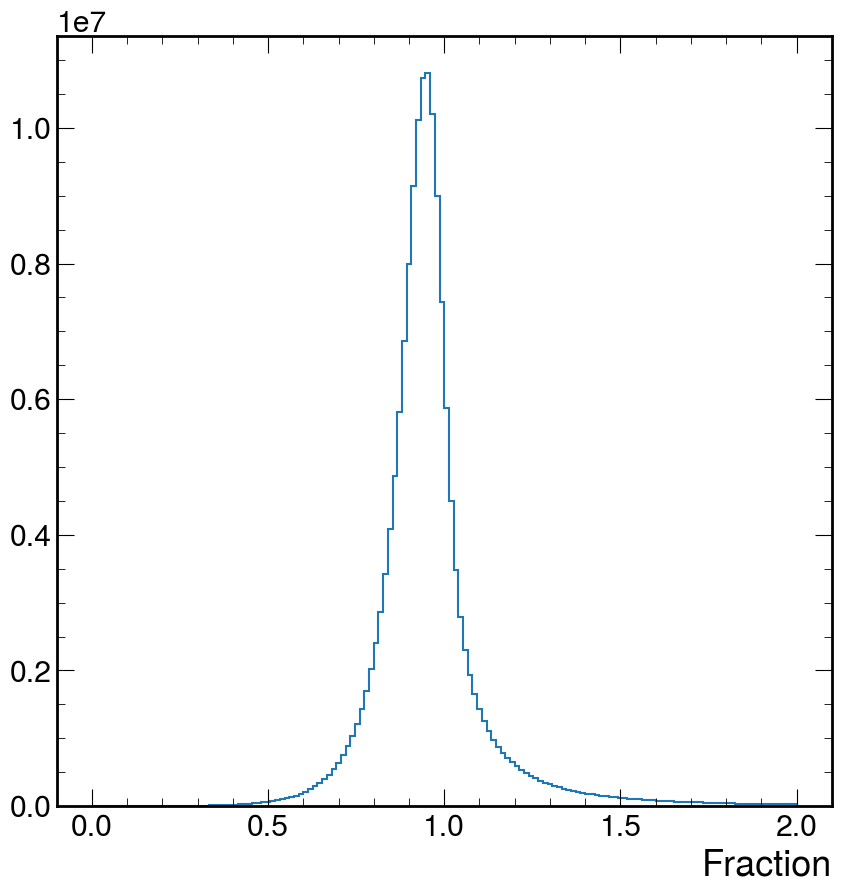

In [6]:
output["pt_reco_over_raw"].project('frac').plot()

### Bin Edges

In [7]:
hist = output["pt_reco_over_raw"]
dataset_bins = hist.axes[0].edges
pt_bins = hist.axes[1].edges
n_PV_bins = hist.axes[2].edges
frac_bins = hist.axes[3].edges
eta_bins = hist.axes[4].edges
pileup_bins = hist.axes[5].edges

### Bin centers

In [8]:
pt_values = hist.axes[1].centers
n_PV_values = hist.axes[2].centers
frac_values = hist.axes[3].centers
eta_values = hist.axes[4].centers
pileup_values = hist.axes[5].centers

### Bin Widths

In [9]:
pt_widths = hist.axes[1].widths
n_PV_widths = hist.axes[2].widths
frac_widths = hist.axes[3].widths
eta_widths = hist.axes[4].widths
pileup_widths = hist.axes[5].widths

In [10]:
pt_widths

array([  10.,   10.,   10.,   10.,   10.,   10.,   10.,   10.,   10.,
         20.,   20.,   20.,   20.,   20.,   50.,   50.,   50.,   50.,
         50.,   50.,  100.,  100.,  100.,  100.,  100.,  500.,  500.,
       1000.])

In [11]:
hist_np = hist.to_numpy()[0]

hist_np.shape

(4, 28, 5, 150, 5, 7)

In [12]:
hist_frac = np.sum(hist_np, axis = (1,2,4,5))

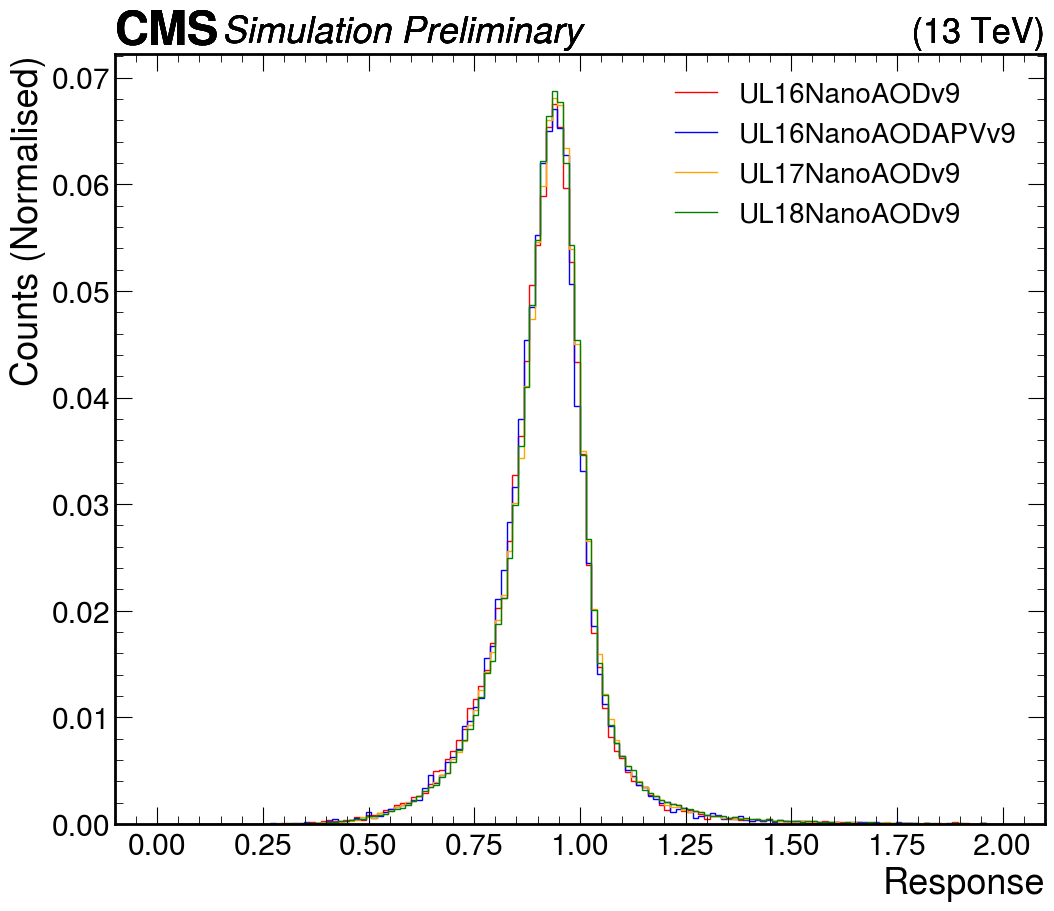

In [13]:
fig = plt.figure(figsize = (12,10))
colors = ['red', 'blue', 'orange' , 'green']
for i in range(4):
    plt.stairs( hist_frac[i]/np.sum(hist_frac[i]),frac_bins,  label = eras_mc[i], color = colors[i])
    plt.xlabel("Response")
    plt.legend(loc = 'upper right', fontsize = 20)
    plt.ylabel("Counts (Normalised)")
    hep.cms.label("Preliminary")

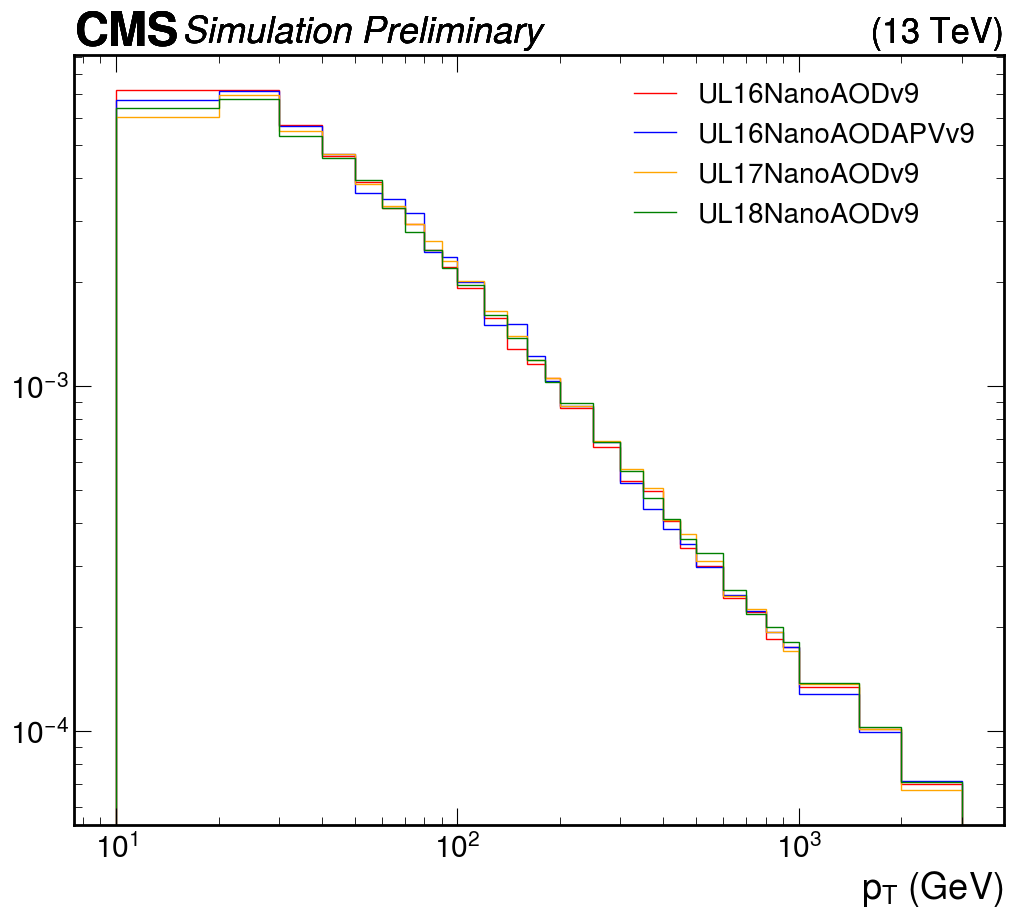

In [14]:
hist_pt = np.sum(hist_np, axis = (2,3,4,5))
colors = ['red', 'blue', 'orange' , 'green']
fig = plt.figure(figsize = (12,10))
for i in range(4):
    plt.stairs( hist_pt[i]/(np.sum(hist_pt[i])* hist.axes[1].widths),pt_bins,  label = eras_mc[i], color = colors[i])
    plt.xlabel(r"$p_T$ (GeV)")
    plt.xscale("log")
    plt.yscale("log")
    plt.legend(loc = 'upper right', fontsize = 20)
    hep.cms.label("Preliminary")

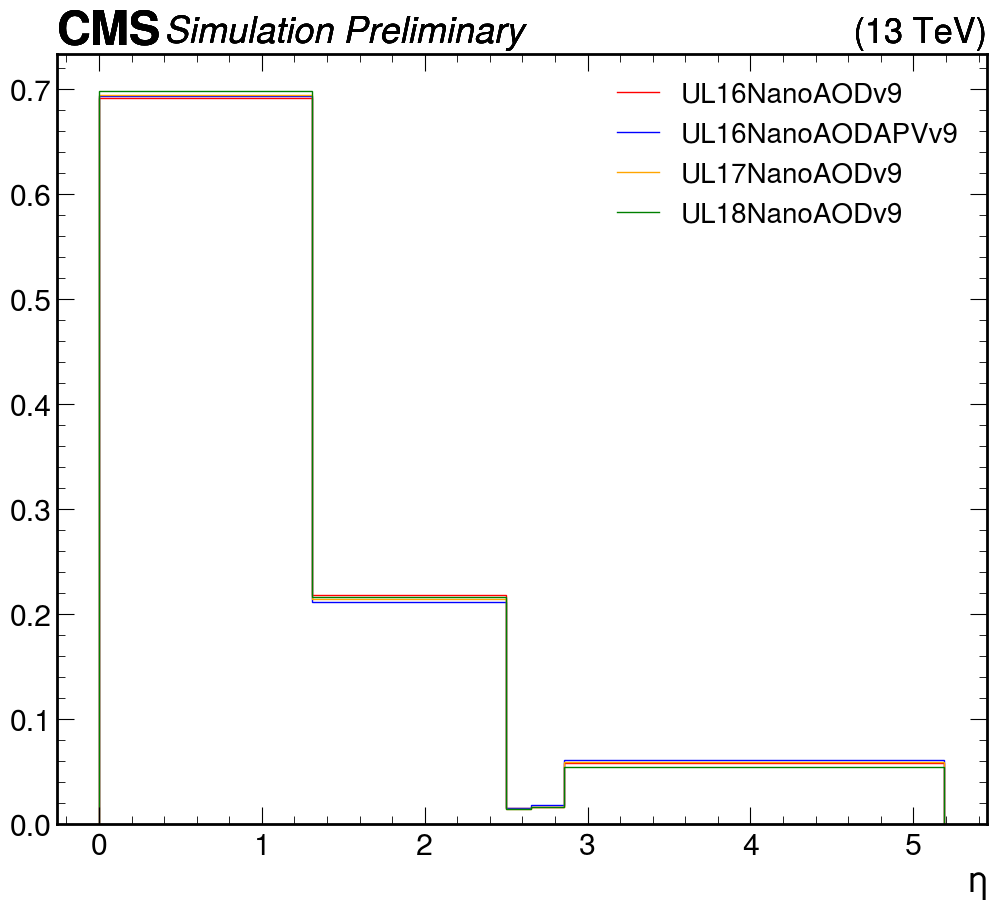

In [15]:
hist_pt = np.sum(hist_np, axis = (2,3,4,5))
colors = ['red', 'blue', 'orange' , 'green']
fig = plt.figure(figsize = (12,10))

hist_eta = np.sum(hist_np, axis = (1,2,3,5))
for i in range(4):
    plt.stairs( hist_eta[i]/np.sum(hist_eta[i]),eta_bins,  label = eras_mc[i], color = colors[i])
    plt.xlabel(r"$\eta$")
    plt.legend(loc = 'upper right', fontsize = 20)
    hep.cms.label("Preliminary")

In [17]:
#hist_frac_pt = np.sum(hist_np, axis = (0,2,4,5) )
hist_frac_pt = hist.project("pt_raw","frac").to_numpy()[0]

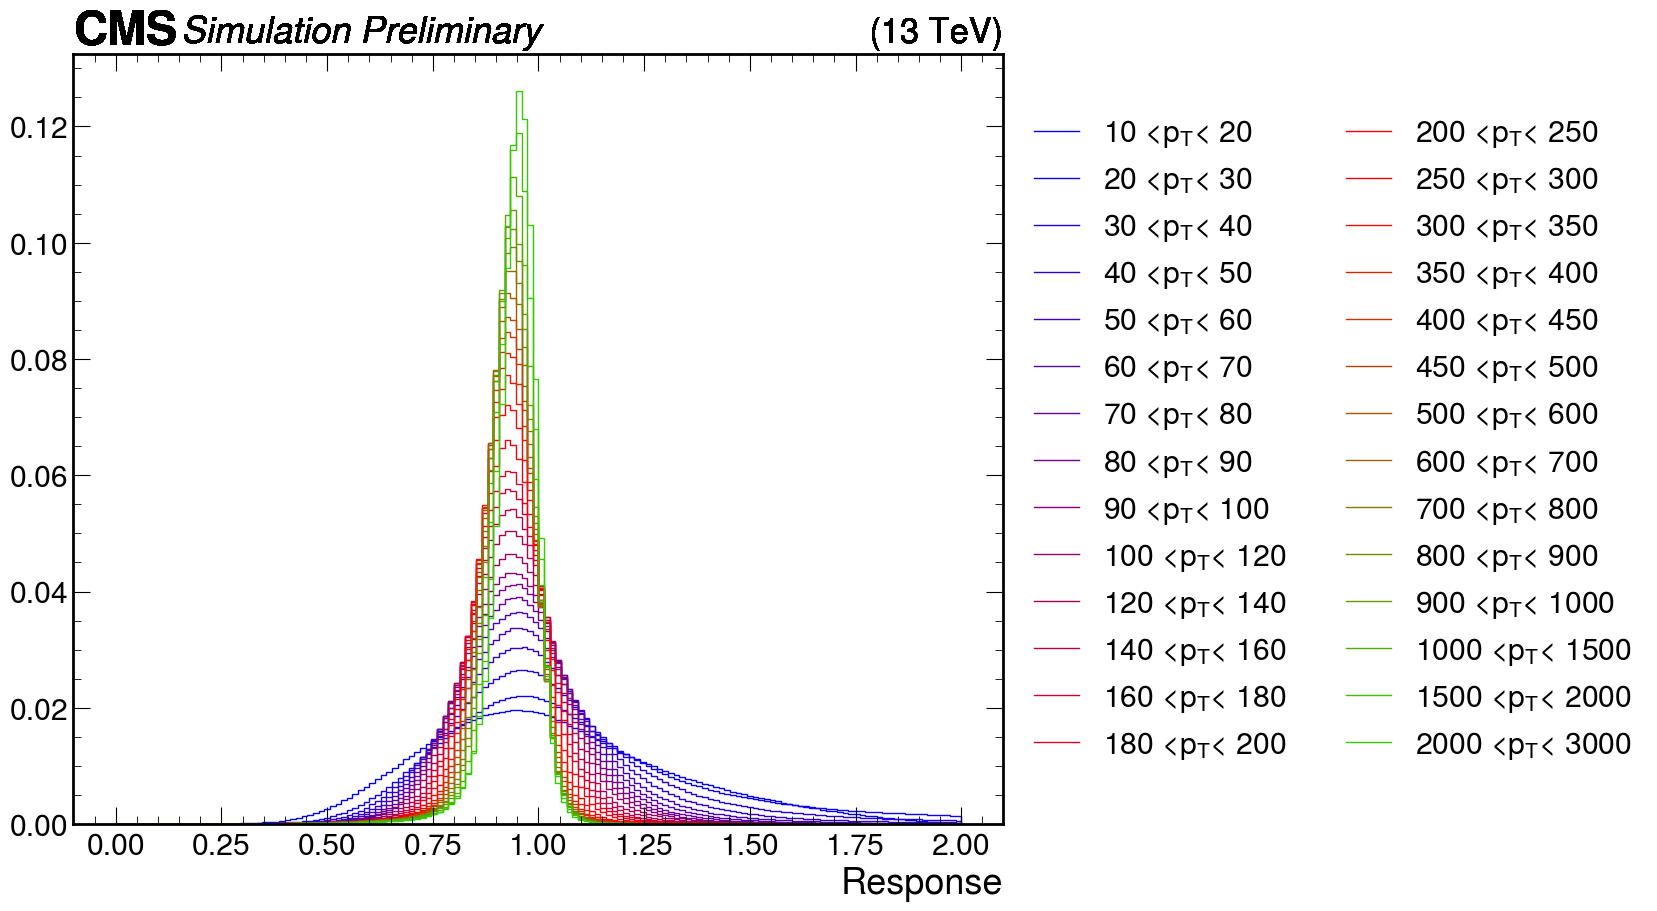

In [18]:
cm = plt.get_cmap('brg')
colors = [cm(1.*i/30) for i in range(28)]
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(28):
    ax.stairs( hist_frac_pt[i]/np.sum(hist_frac_pt[i]),frac_bins,  label = str(int(pt_bins[i]))+r" <$p_T$< "  + str(int(pt_bins[i+1])) )
    ax.set_xlabel("Response")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    hep.cms.label("Preliminary")

In [25]:
from scipy.optimize import curve_fit

class Histfit:
    def __init__(self, hist_frac_pt, frac_values, pt_values):
        self.frac_values = frac_values
        self.hist_frac_pt = hist_frac_pt
        self.pt_values = pt_values
        
        self.parameters = {"mean":np.full(len(self.pt_values), None), "sigma": np.full(len(self.pt_values), None), "const":np.full(len(self.pt_values), None),"sigmaErr":np.full(len(self.pt_values), None)
                          ,"meanErr":np.full(len(self.pt_values), None)}
        
    def gauss(self,x,  x0, sigma,a):
        return (a*(1/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x - x0) ** 2 / (2 * sigma ** 2)))
    
    def fitGauss(self, hist_frac, frac_values):
        parameters, covariance = curve_fit(self.gauss, frac_values, hist_frac) #,bounds = ([0.5,0.05,-5],[2,0.3,20])
        mean = parameters[0]
        sigma = parameters[1]
        const = parameters[2]
        meanErr = covariance[0][0]
        sigmaErr = covariance[1][1]
        return mean,sigma,const, sigmaErr, meanErr
    
    def initiate_parameters(self):
        for i in range(len(self.hist_frac_pt)):
            hist_frac = self.hist_frac_pt[i]
            results = self.fitGauss(hist_frac, self.frac_values)
            for j,key in enumerate(self.parameters.keys()):
                self.parameters[key][i] = results[j]
                
    def store_parameters(self):
        self.initiate_parameters()
        for repeater in range(2):
            for i,hist_frac in enumerate(self.hist_frac_pt):
                sel = (self.frac_values > (self.parameters["mean"][i] - 1.5*self.parameters["sigma"][i])) &  (self.frac_values < (self.parameters["mean"][i] + 1.5*self.parameters["sigma"][i]))
                frac_values = self.frac_values[sel]
                hist_frac = hist_frac[sel]

                results = self.fitGauss(hist_frac, frac_values)
                for j,key in enumerate(self.parameters.keys()):
                    self.parameters[key][i] = results[j]
    def show_fit(self, i):
        hist_frac = self.hist_frac_pt[i]
        sel = (self.frac_values > (self.parameters["mean"][i] - 1.5*self.parameters["sigma"][i])) &  (self.frac_values < (self.parameters["mean"][i] + 1.5*self.parameters["sigma"][i]))
        frac_values = self.frac_values[sel]
        hist_frac = hist_frac[sel]
        results = self.fitGauss(hist_frac, frac_values)
        
        print("Mean: {} ".format(results[0]))
        print("Width: {}".format(results[1]))
        for j,key in enumerate(self.parameters.keys()):
                    self.parameters[key][i] = results[j]
                
        plt.plot(self.frac_values, self.hist_frac_pt[i], 'b-')
        plt.plot(frac_values, self.gauss(frac_values, results[0], results[1], results[2]), 'black')
            
        

In [26]:
histfit = Histfit(hist_frac_pt, frac_values, pt_values)

In [27]:
histfit.store_parameters()

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

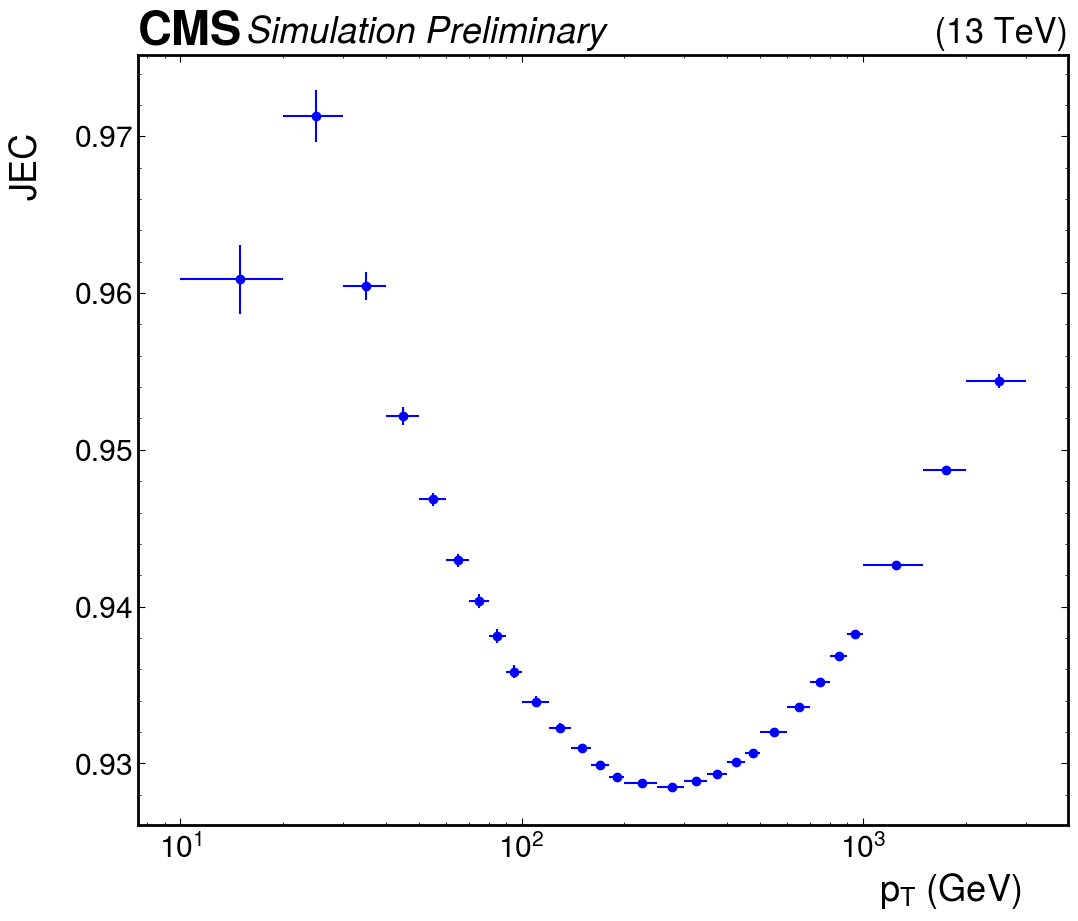

In [29]:
mean_list = histfit.parameters["mean"]
mean_error_list  = histfit.parameters["meanErr"]
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
ax.errorbar(histfit.pt_values, mean_list, np.power(mean_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JEC", xscale = 'log')
hep.cms.label("Preliminary")
#plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

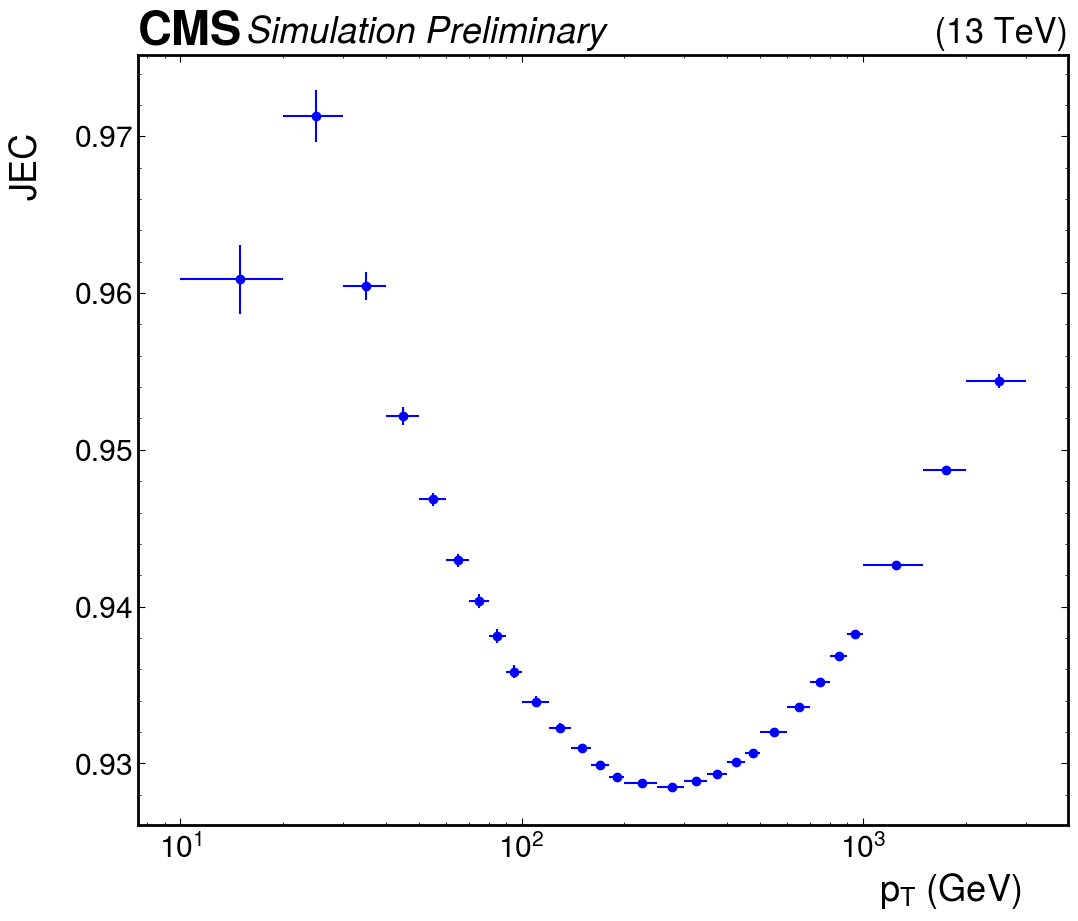

In [30]:
mean_list = histfit.parameters["mean"]
mean_error_list  = histfit.parameters["meanErr"]
fig = plt.figure(figsize = (12,10))
ax = plt.subplot()
ax.errorbar(histfit.pt_values, mean_list, np.power(mean_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JEC", xscale = 'log')
hep.cms.label("Preliminary")
#plt.xscale("log")

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

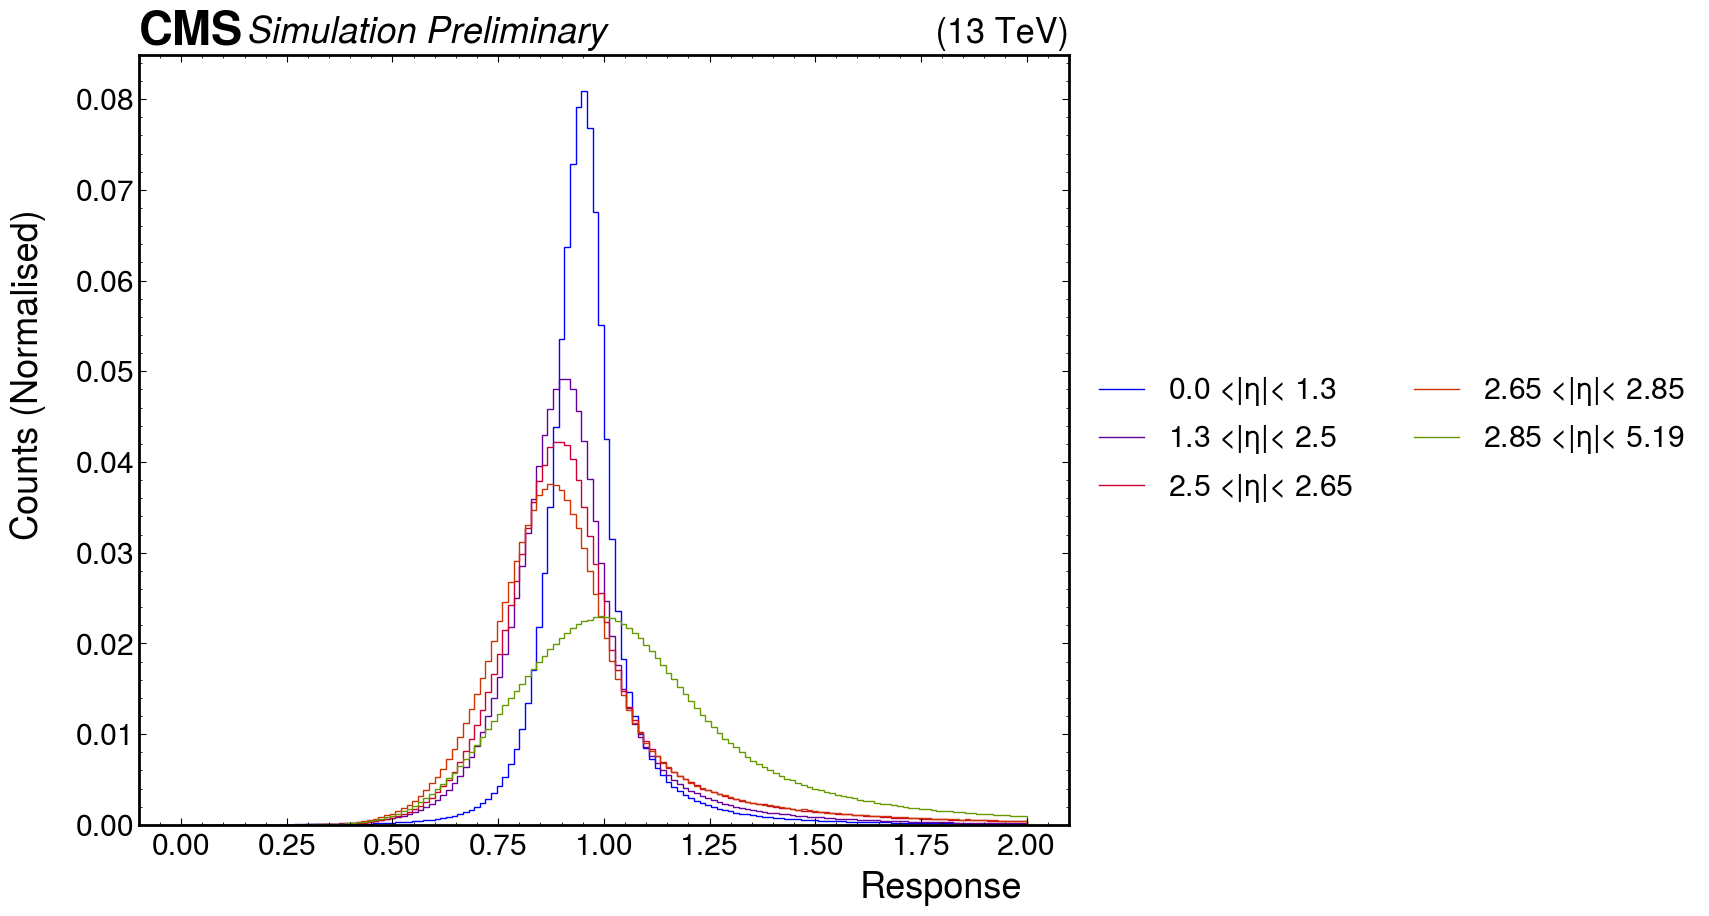

In [33]:
#hist_frac_eta = np.sum(hist_np, axis = (0,1,2,5) )
#hist_frac_eta = hist_frac_eta.T
fig = plt.figure(figsize = (12,10))

hist_frac_eta = hist.project('eta','frac').to_numpy()[0]
cm = plt.get_cmap('brg')
colors = [cm(1.*i/5) for i in range(15)]
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(5):
    ax.stairs( hist_frac_eta[i]/np.sum(hist_frac_eta[i]),frac_bins,  label = str(round(eta_bins[i],2))+r" <$|\eta|$< "  + str(round(eta_bins[i+1],2)) )
    ax.set_xlabel("Response")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
    adjust_plot(ax, ylabel = "Counts (Normalised)", ylabel_coord=0.8)
hep.cms.label("Preliminary")

In [34]:
histfit_eta = Histfit(hist_frac_eta, frac_values, eta_values)
histfit_eta.store_parameters()

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

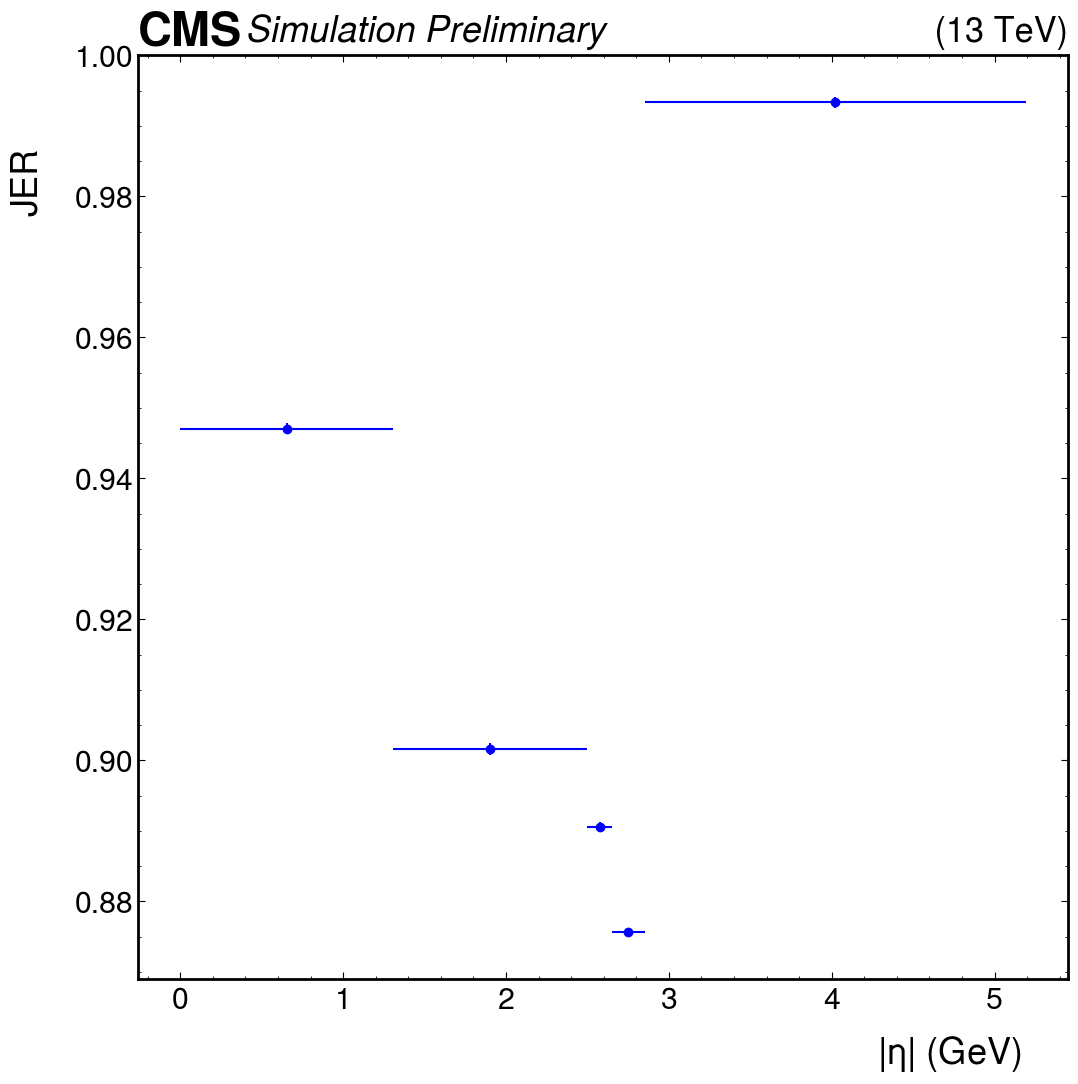

In [36]:
fig = plt.figure(figsize = (12,12))
mean_list = histfit_eta.parameters["mean"]
mean_error_list  = histfit_eta.parameters["meanErr"]

ax = plt.subplot()
ax.errorbar(eta_values, mean_list, np.power(mean_error_list, 0.5), xerr = eta_widths/2,  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$|\eta|$ (GeV)", ylabel = "JER")
#plt.xscale("log")
hep.cms.label("Preliminary")

Mean: 0.9933295315679694 
Width: 0.21597065265431903


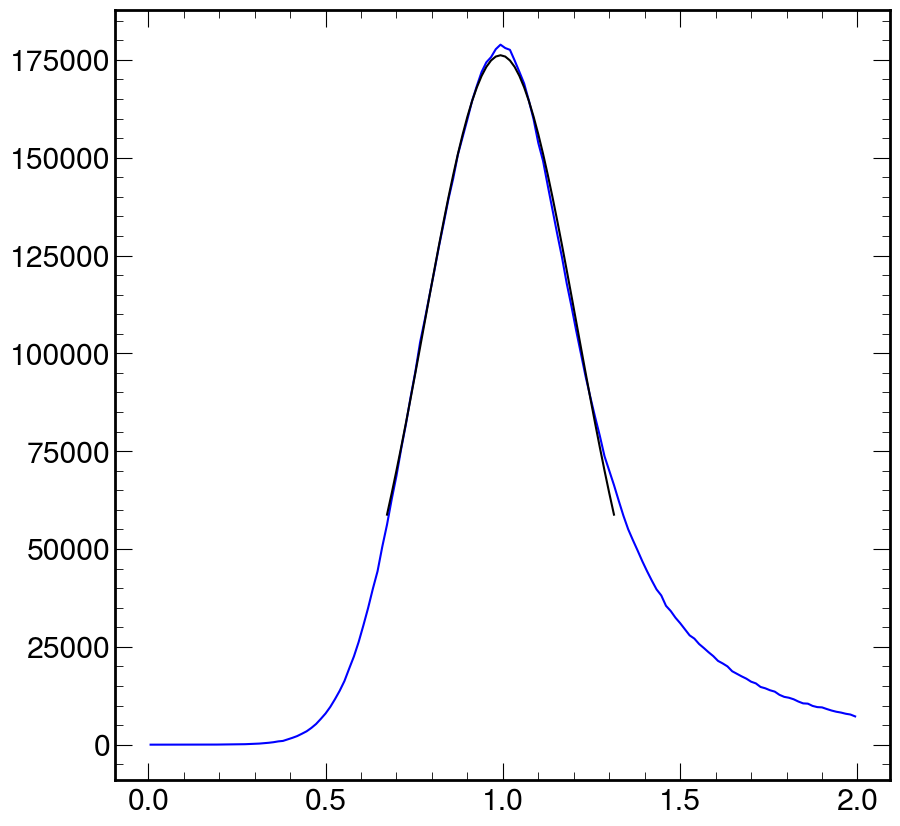

In [515]:
histfit_eta.show_fit(4)

(exptext: Custom Text(0.0, 1, 'CMS'),
 expsuffix: Custom Text(0.0, 1.005, 'Simulation Preliminary'))

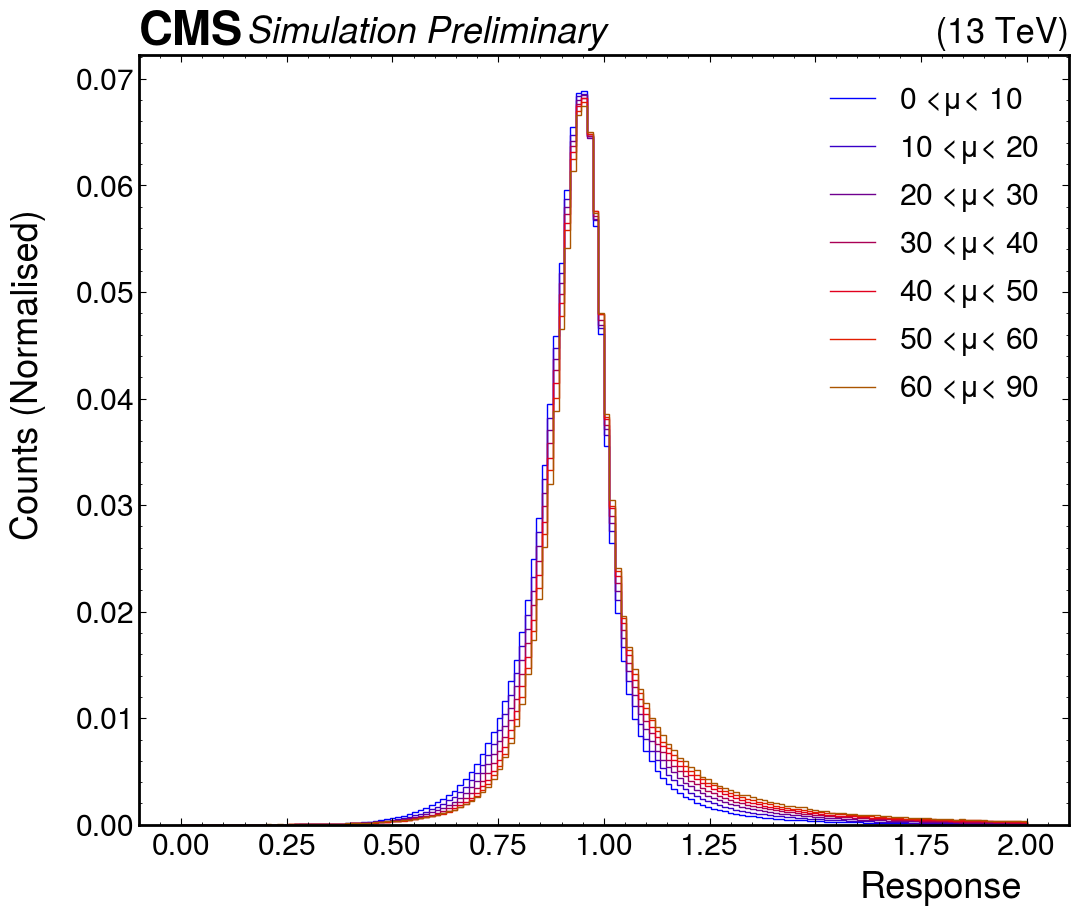

In [37]:
fig = plt.figure(figsize = (12,10))
hist_frac_pileup = hist.project("pileup","frac").to_numpy()[0]
cm = plt.get_cmap('brg')
colors = [cm(1.*i/9) for i in range(9)]
ax = plt.subplot()
ax.set_prop_cycle(color=colors)
for i in range(7):
    ax.stairs( hist_frac_pileup[i]/np.sum(hist_frac_pileup[i]),frac_bins,  label = str(int(pileup_bins[i]))+r" <$\mu$< "  + str(int(pileup_bins[i+1])) )
    ax.set_xlabel("Response")
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)
adjust_plot(ax, ylabel = "Counts (Normalised)", ylabel_coord=0.8)
ax.legend() 
hep.cms.label("Preliminary")

In [38]:
# for i in range(len(hist_frac_pileup)):
#     hist_frac_pileup[i] = hist_frac_pileup[i]/np.sum(hist_frac_pileup[i])
    
histfit_frac_pileup = Histfit(hist_frac_pileup, frac_values, pileup_values)
histfit_frac_pileup.store_parameters()

In [39]:
hist_frac_pileup.shape

(7, 150)

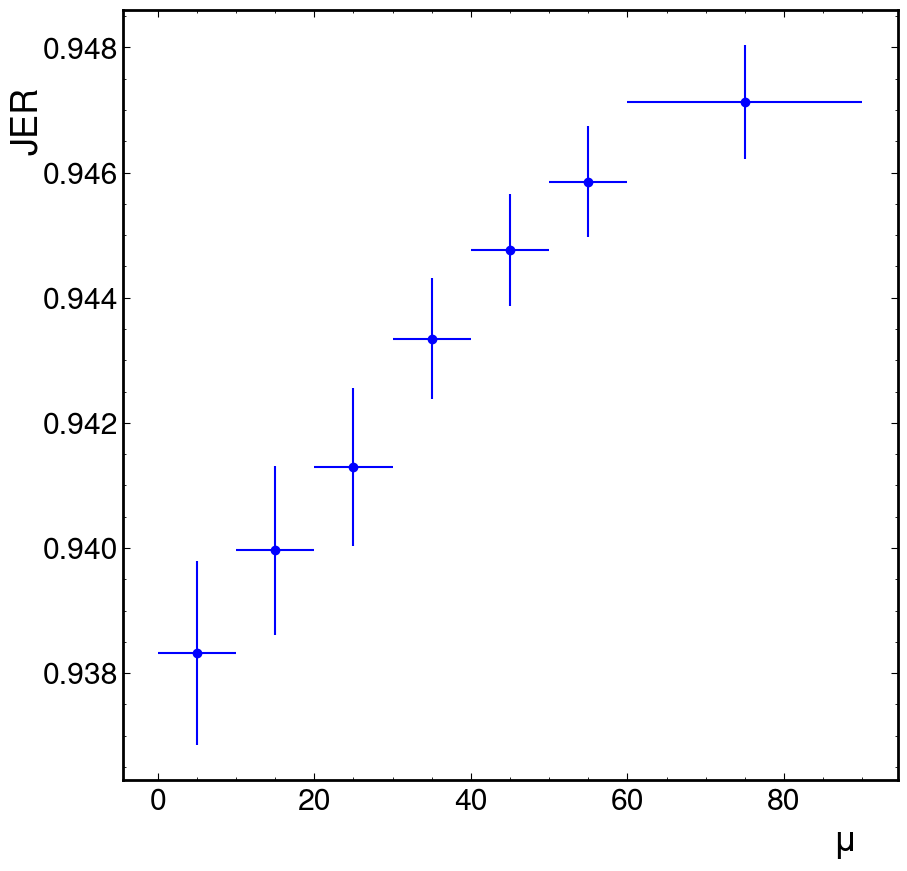

In [41]:
mean_list = histfit_frac_pileup.parameters["mean"]
mean_error_list  = histfit_frac_pileup.parameters["meanErr"]

ax = plt.subplot()
ax.errorbar(pileup_values[:], mean_list[:], np.power(mean_error_list[:], 0.5), xerr = pileup_widths[:]/2,  marker = 'o', linestyle = "", color = 'b', label = r'JER')
#plt.xlabel(r"$p_T$ (GeV)")
adjust_plot(ax, xlabel = r"$\mu$ ", ylabel = "JER")
#plt.xscale("log")


Mean: 0.9433420094301798 
Width: 0.06079888906935723


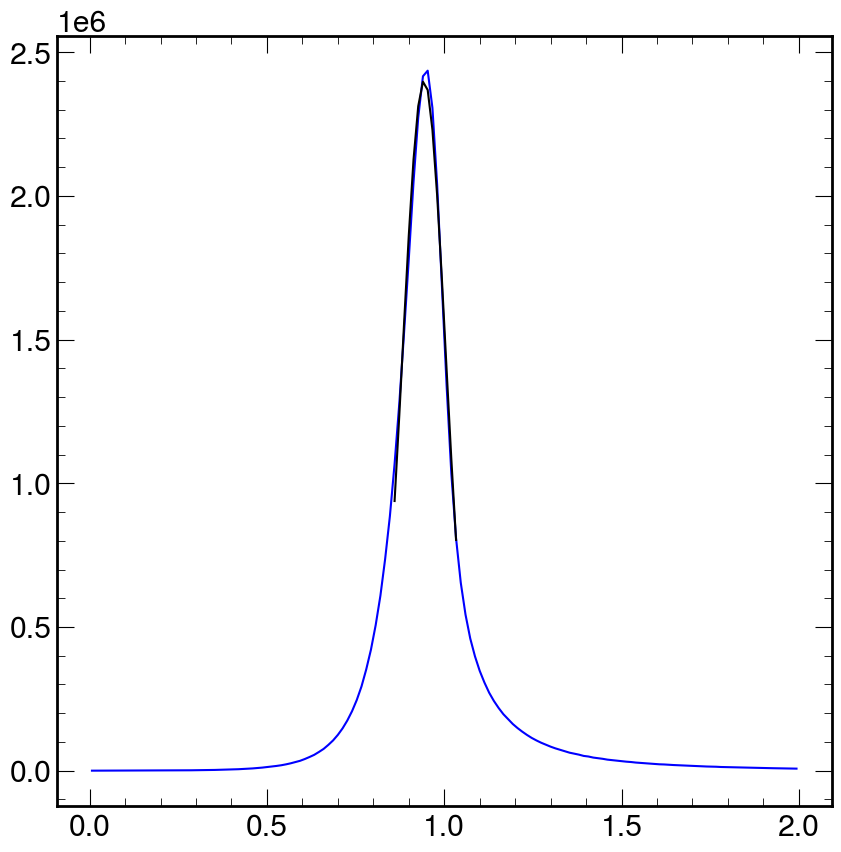

In [524]:

histfit_frac_pileup.show_fit(3)

In [46]:
hist_pileup_pt_frac = hist.project("pileup","pt_raw","frac").to_numpy()[0]

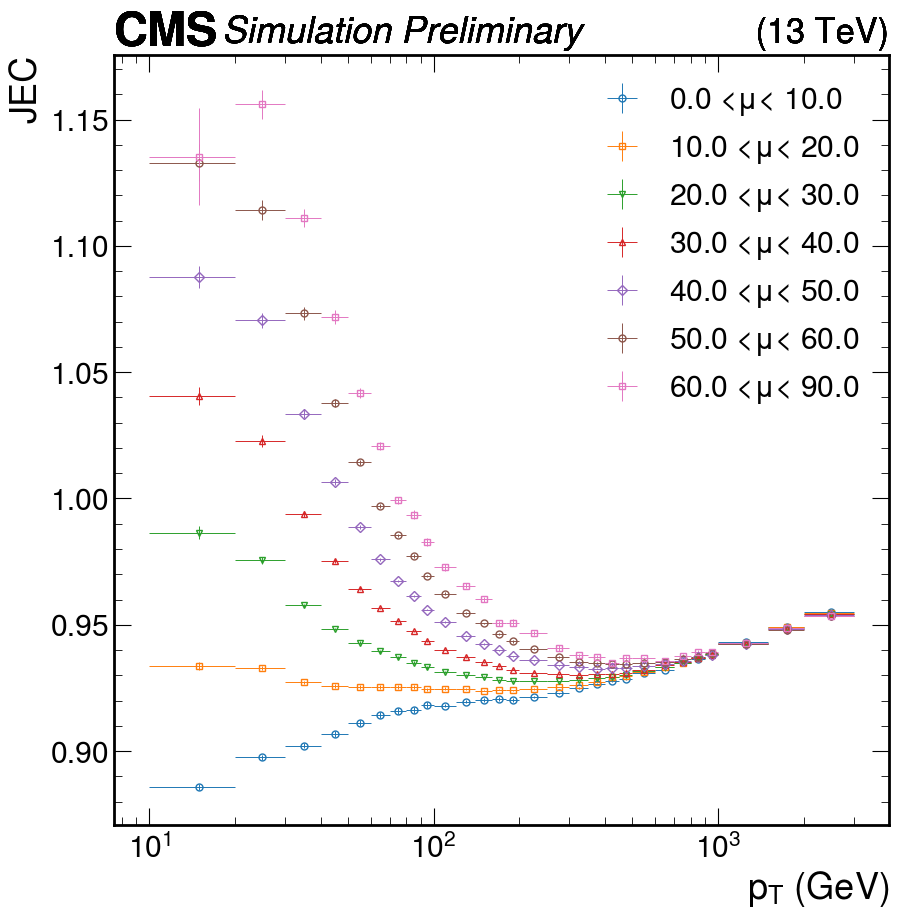

In [48]:
import itertools
ax = plt.subplot()
markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
for i_pileup, hist_pt_frac in enumerate(hist_pileup_pt_frac):
    histfit = Histfit(hist_pt_frac, frac_values, pt_values)
    histfit.store_parameters()
    
    mean_list = histfit.parameters["mean"]
    mean_error_list  = histfit.parameters["meanErr"]

    ax.errorbar(pt_values, mean_list, np.power(mean_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  label = str(round(pileup_bins[i_pileup],2))+r" <$\mu$< "  + str(round(pileup_bins[i_pileup+1],2)), fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)
    plt.xlabel(r"$p_T$ (GeV)")
    plt.ylabel("JEC")
    plt.xscale("log")
    hep.cms.label("Preliminary")
    plt.legend()
    #adjust_plot(ax, xlabel = r"$p_T$ (GeV)", ylabel = "JER",show_legend=True, ylabel_coord=0.9, xscale= 'log')

In [318]:
hist_eta_pileup_pt_frac = hist.project("eta","pileup","pt","frac").to_numpy()[0]

In [615]:

# markers = itertools.cycle(['o', 's', 'v', '^', 'D'])
# for i_eta,hist_pileup_pt_frac in enumerate(hist_eta_pileup_pt_frac):
#     ax = plt.subplot()
#     for i_pileup, hist_pt_frac in enumerate(hist_pileup_pt_frac):
#         histfit = Histfit(hist_pt_frac, frac_values, pt_values)
#         histfit.store_parameters()

#         sigma_list = histfit.parameters["sigma"]
#         sigma_error_list  = histfit.parameters["sigmaErr"]

        
#         ax.errorbar(pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = pt_widths/2,   linestyle = "",  label = str(round(pileup_bins[i_pileup],2))+r" <$\mu$< "  + str(round(pileup_bins[i_pileup+1],2)), fmt = next(markers), markersize = 5, markerfacecolor='none', linewidth = 0.7)
        
#         plt.xlabel(r"$p_T$ (GeV)")
#         plt.ylabel("JER")
#         plt.xscale("log")
#         hep.cms.label("Preliminary")
#         plt.legend()
#         #adjust_plot(ax, xlabel = r"$p_T$ (GeV)", ylabel = "JER",show_legend=True, ylabel_coord=0.9, xscale= 'log')
#     ax.text(s = str(round(eta_bins[i_eta],3))+ r" <$\eta$< " + str(round(eta_bins[i_eta + 1],3)), x = 0.35, y = 0.93, fontsize = 21, transform=ax.transAxes)
#     plt.show()

In [ ]:

# histfit = Histfit(hist_eta_pileup_pt_frac[10][5], frac_values, pt_values)
# histfit.store_parameters()

In [616]:
# sigma_list = histfit.parameters["sigma"]
# sigma_error_list  = histfit.parameters["sigmaErr"]
# fig = plt.figure(figsize = (12,10))
# ax = plt.subplot()
# ax.errorbar(histfit.pt_values, sigma_list, np.power(sigma_error_list, 0.5), xerr = 0.5*np.array(pt_widths),  marker = 'o', linestyle = "", color = 'b', label = r'JER')
# #plt.xlabel(r"$p_T$ (GeV)")
# adjust_plot(ax, xlabel = r"$p_{T}$ (GeV)", ylabel = "JER", xscale = 'log')
# hep.cms.label("Preliminary")
# #plt.xscale("log")

In [286]:
eta_values

array([0.6525, 1.9025, 2.575 , 2.7515, 4.022 ])

In [610]:
median_list = np.array([])
for i in range(1,27):
    median = np.median(np.loadtxt(str(i)+".txt"))
    print(median)
    median_list = np.concatenate((median_list, median), axis = None)

1.3582176000000001
1.0893302500000002
1.0369701
1.0205832
1.0138707
1.0100794
1.0077091
1.0060351
1.0046269
1.0035571
1.0025139
1.0022886
1.0020041
1.0013654
1.0006806
1.00041815
1.0000384
0.9997769
0.9995801
0.9995047
0.999474135
0.9995237
0.9995614500000001
0.9995574
0.99967325
0.999791


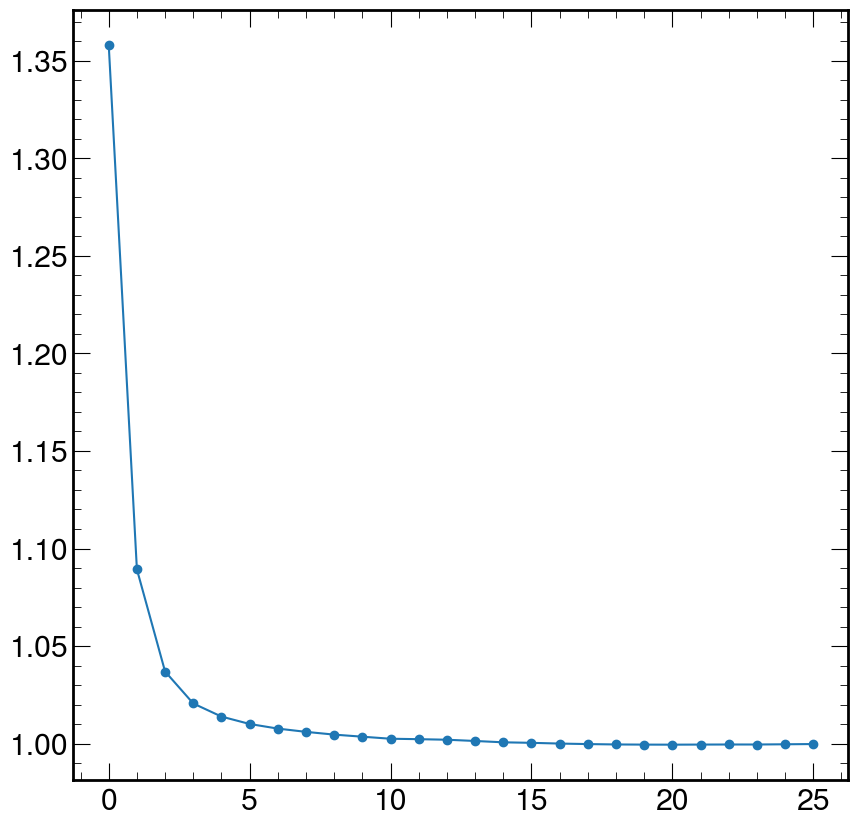

In [614]:
plt.plot(median_list, marker = 'o')